# Homework 7
## Alex Pine (akp258@nyu.edu)

### Problem 1: Quantile Regression

The code below loads the data, computes Y*, and regresses it with the 'ed76' column for the 0.5, 0.7, and 0.9 quantiles.

Loading required package: quantreg
Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve

Loading required package: ggplot2


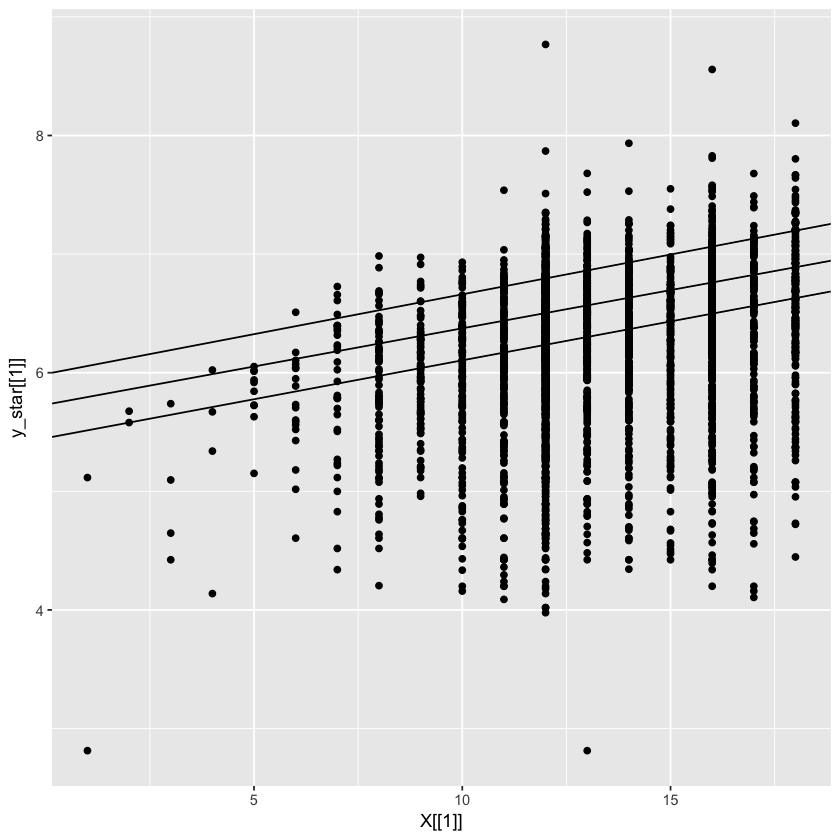

In [1]:
require('quantreg')
require('ggplot2')

df = read.table("~/causal/hw7/Card_nls.csv", header=TRUE, sep=';')

avg_wage = (df['wage76'] + df['wage78'] + df['wage80']) / 3
# remove rows with zero wages
df = df[avg_wage != 0.0,]

y_star = log((df['wage76'] + df['wage78'] + df['wage80']) / 3)

X = df['ed76']

qr1 = rq(y_star[[1]] ~ X[[1]], tau=c(0.5, 0.7, 0.9))
ggplot(df, aes(X[[1]], y_star[[1]])) + geom_point() + 
  geom_abline(intercept=coef(qr1)[1], slope=coef(qr1)[2]) +
  geom_abline(intercept=coef(qr1)[3], slope=coef(qr1)[4]) +
  geom_abline(intercept=coef(qr1)[5], slope=coef(qr1)[6])

From this graph it's clear that the 'rq' library is using the 'location shift' model. This means the different quantiles only affect alpha, and the beta parameter is the same for all three regressions. Printing out the cofficents, we get:

In [3]:
qr1

Call:
rq(formula = y_star[[1]] ~ X[[1]], tau = c(0.5, 0.7, 0.9))

Coefficients:
              tau= 0.5   tau= 0.7   tau= 0.9
(Intercept) 5.44841561 5.73043788 5.98940084
X[[1]]      0.06565711 0.06444593 0.06719208

Degrees of freedom: 3273 total; 3271 residual

Indeed, the beta coeffients are all equal, execept for optimization error:
 
|       | tau=0.5 | tau=0.7 | tau=0.9 
|-------|---------|---------|---------|
| alpha | 5.448   | 5.730   | 5.990   
| beta  | 0.066   | 0.064   | 0.067   

This regression poorly captures the effect of education on wages because the location-scale model assumes that the nuisance variable is not correlated with the treatment. Since the model doesn't take into account cofounders like natural ability, this model shouldn't be trusted to measure the treatment effect.

### 2 Plot quantile treatment effect for $\tau = 0.5$ using D

Slide 19 of lecture 9 states:

"Under perfect randomization, $Q^0(\tau)$ and $Q^1(\tau)$ are computed as the
quantiles of $Y^∗$ conditional of $D = 0$ and conditional on $D = 1$, respectively."

First we'll find $Q_1(\tau), \forall \tau \in [0,1]$, the quantiles of people who went to college:

In [19]:
# Graphing quantiles from zero to 1 by 0.05 increments.
qs = seq(0, 1, 0.05)

college_df = df[df['ed76'] > 15,]
yd1 = log((college_df['wage76'] + college_df['wage78'] + college_df['wage80']) / 3)
q_yd1 = quantile(yd1[[1]], probs=qs)

Next we'll find $Q_0(\tau), \forall \tau \in [0,1]$, the quantiles of people who did not go to college:

In [20]:
nocollege_df = df[df['ed76'] <= 15,]
yd0 = log((nocollege_df['wage76'] + nocollege_df['wage78'] + nocollege_df['wage80']) / 3)
q_yd0 = quantile(yd0[[1]], probs=qs)

Under perfect randomization, their difference is the QTE, which I compute and plot below against all quartiles:

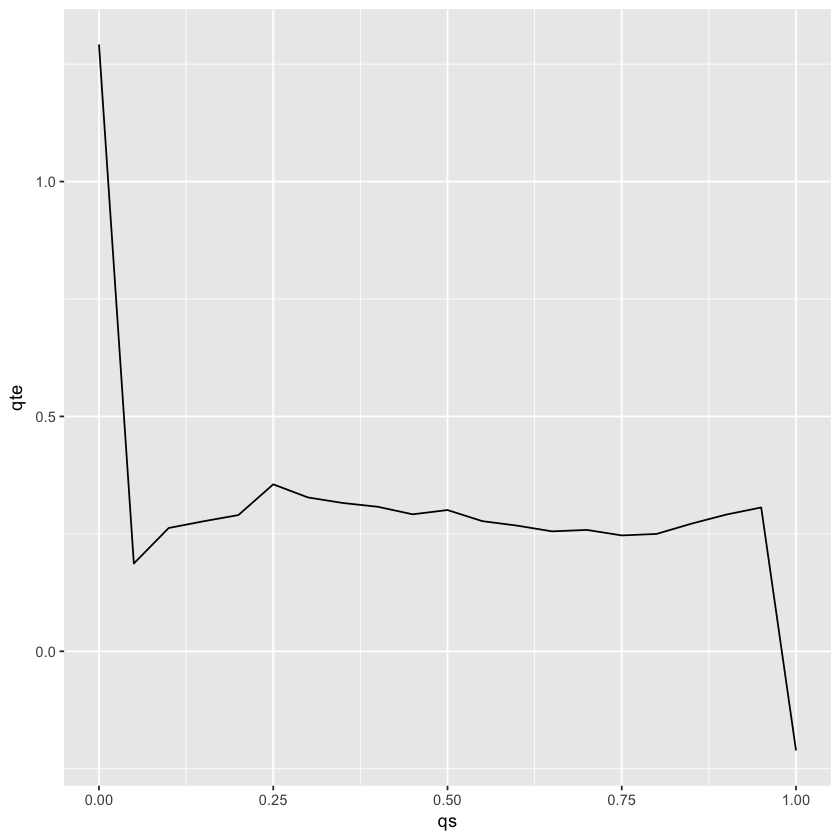

In [21]:
qte = q_yd1 - q_yd0
qplot(qs, qte, geom='line')

### Problem 3

### 3a: Compute LATE

In [10]:
D = ifelse(df['ed76'] > 15, 1, 0)
Z = df['nearc4']

# delta_late = (E[Y*|Z=1] - E[Y*|Z=0]) / (E[D*|Z=1] - E[D*|Z=0])
delta_late = (mean(y_star[Z == 1]) - mean(y_star[Z == 0])) / 
             (mean(D[Z == 1]) - mean(D[Z == 0]))
print(delta_late)

[1] 2.103332


The Local treatment effect is 2.1.

### 3b: Compute IVQR

In the code below I construct functions for the two equations, and then grid search over values of $q^0_{\tau}$ and $\delta_{\tau}$ for $\tau = 0.5$:

In [11]:
taus = rep(0.5, length(y_star[[1]]))

# function for the first equation
first_eq = function(q, delta) {
  qs = rep(q, length(y_star[[1]]))
  deltas = rep(delta, length(delta))
  indicators = y_star[[1]] <= qs + deltas*D
  return(mean(indicators - taus))
}  
# function for the second equation
second_eq = function(q, delta) {
  qs = rep(q, length(y_star[[1]]))
  deltas = rep(delta, length(delta))
  indicators = y_star[[1]] <= qs + deltas*D
  return(mean((indicators - taus) * Z[[1]]))
}  

# y_star goes from 2.81 to 8.76, so q should be in that range
# delta can be zero if there's no effect. if there is, the biggest it could be is 
# max(y_star) - 1 - min(y_star) ~= 5.0
best_q = NULL  # The q value that minimizes the equations the most.
best_delta = NULL  # The delta value that minimizes the equations the most.
best_dist = NULL # I choose a best q and delta by measuring their MSE from the origin
best_first = NULL # 
best_second = NULL
for (q in seq(2.81, 8.76, 0.01)) {
  for (delta in seq(0.0, 5.0, 0.01)) {
    first = first_eq(q, delta)
    second = second_eq(q, delta)
    dist = first^2 + second^2
    if (is.null(best_dist) || dist < best_dist) {
      best_q = q
      best_delta = delta
      best_dist = dist
      best_first = first
      best_second = second
    }
  }
}
best_q # 5.94
best_delta # 1.74
best_dist # 1.069e-05
best_first # 0.002
best_second # -0.003

[1] 5.94

[1] 1.74

[1] 1.068842e-05

[1] 0.001985946

[1] -0.002597006

The grid search found the best value for $\delta_{\tau=0.5}$ to be 1.74.